In [1]:
import time
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

2024-12-11 15:57:46.265904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 15:57:46.274885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733907466.285096    7338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733907466.288031    7338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:57:46.300010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set data dir
data_dir = pathlib.Path('data/')

# Display dataset info
print('Training: ')
print(f'Total of class 0 images: {len(list(data_dir.glob('train_signs/0/*')))}')
print(f'Total of class 1 images: {len(list(data_dir.glob('train_signs/1/*')))}')
print(f'Total of class 2 images: {len(list(data_dir.glob('train_signs/2/*')))}')
print(f'Total of class 3 images: {len(list(data_dir.glob('train_signs/3/*')))}')
print(f'Total of class 4 images: {len(list(data_dir.glob('train_signs/4/*')))}')
print(f'Total of class 5 images: {len(list(data_dir.glob('train_signs/5/*')))}')

Training: 
Total of class 0 images: 141
Total of class 1 images: 146
Total of class 2 images: 142
Total of class 3 images: 142
Total of class 4 images: 144
Total of class 5 images: 149


In [3]:
# Load the dataset
# Define some params:
batch_size = 32
img_height = 128
img_width = 128

train_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train_signs'),
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'val_signs'),
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'test_signs'),
    seed=123,
    image_size=(img_height, img_width),
    batch_size=120
)

Found 864 files belonging to 6 classes.
Found 216 files belonging to 6 classes.
Found 120 files belonging to 6 classes.


2024-12-11 15:57:47.557600: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


['0', '1', '2', '3', '4', '5']


2024-12-11 15:57:48.004545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


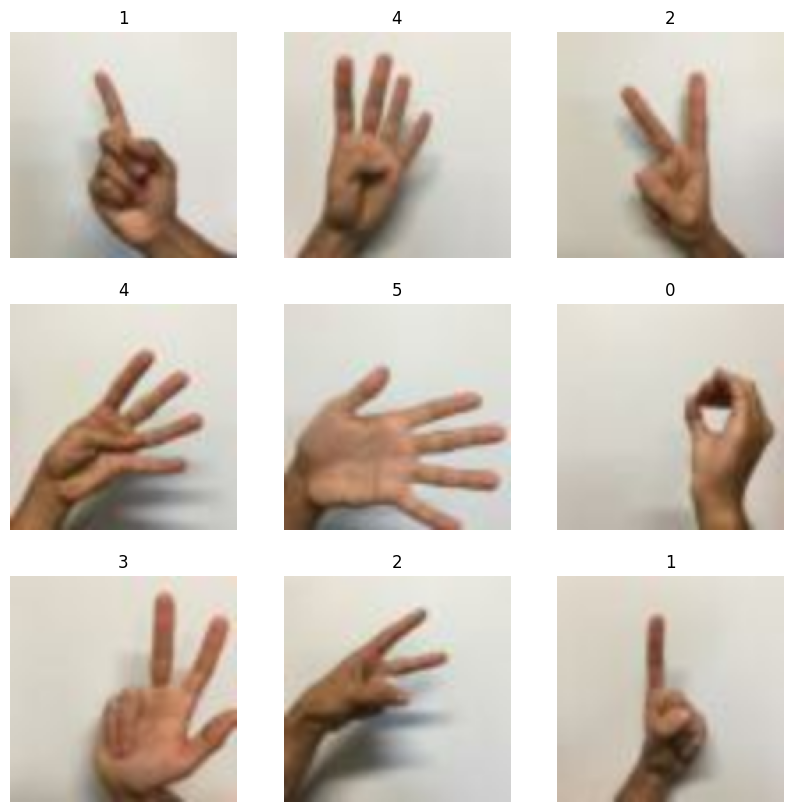

In [4]:
# Display all classes
class_names = train_ds.class_names
print(class_names)

# Show 9 images
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

2024-12-11 15:57:48.524681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


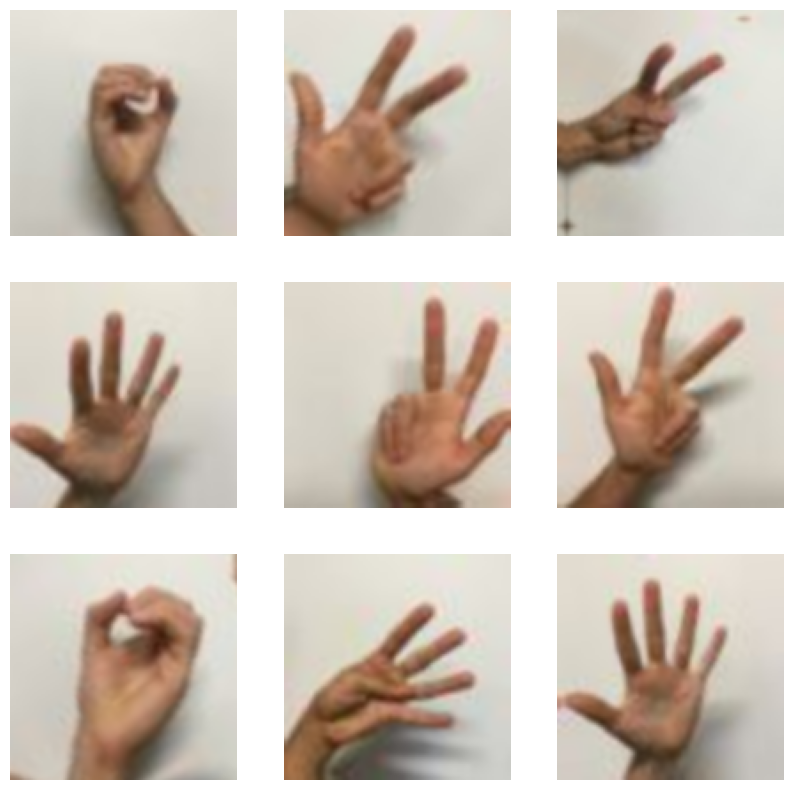

In [5]:
# Overfitting problem
# Implementation data augmentation
from keras import Sequential

data_augmentation = Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


# Visualize a few augmented examples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")


In [6]:

num_classes = len(class_names)
# Define the model
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),  # Rescale input
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,454 (16.36 MB)

 Trainable params: 4,288,454 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training
start_time = time.time()

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60} minutes")

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.1915 - loss: 2.3577 - val_accuracy: 0.2176 - val_loss: 1.7896
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.1952 - loss: 1.7917 - val_accuracy: 0.1759 - val_loss: 1.7876
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.2002 - loss: 1.7829 - val_accuracy: 0.1667 - val_loss: 1.6952
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.2869 - loss: 1.6647 - val_accuracy: 0.3889 - val_loss: 1.5012
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4455 - loss: 1.4636 - val_accuracy: 0.4259 - val_loss: 1.3073
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4312 - loss: 1.4078 - val_accuracy: 0.4907 - val_loss: 1.2385
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5107 - loss: 1.2610 - val_accuracy: 0.5972 - val_loss: 1.0537
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6082 - loss: 1.1258 - val_accuracy: 0.

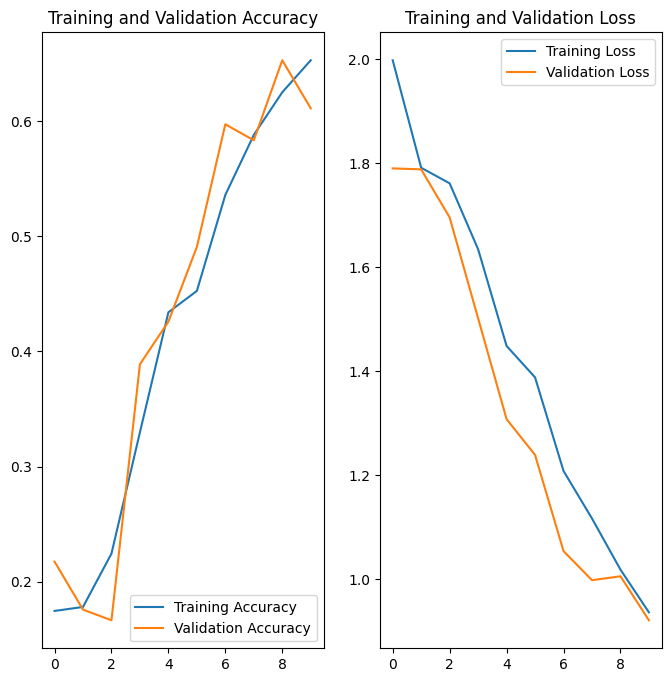

In [8]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Save model
model_path = pathlib.Path('model')
model.save(os.path.join(model_path,'model.keras'))

# Load model
trained_model = tf.keras.models.load_model(os.path.join(model_path,'model.keras'))

In [10]:
# Evaluate the model
loss, accuracy = trained_model.evaluate(test_ds, verbose=1)
print(f'Test accuracy : {accuracy * 100}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6583 - loss: 0.8496
Test accuracy : 65.83333611488342


In [11]:
# Specify test image filename
test_img_fn = os.path.join(data_dir, 'test_signs/5/5_IMG_5470.jpg')

# Read img
img = keras.preprocessing.image.load_img(
    test_img_fn, target_size=(img_height, img_width)
)

# Convert image into array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prob = trained_model.predict(img_array)
predicted_class = class_names[np.argmax(prob)]

print(f'Predict class: {predicted_class} with probability = {np.max(prob)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predict class: 5 with probability = 0.9372848868370056
